In [55]:
import collections
import enum
import functools
import random

from mesa import Agent, Model
from mesa.datacollection import DataCollector
from mesa.space import SingleGrid
from mesa.time import RandomActivation


num_rounds = 10     # m in the whitepaper
num_nodes = 1000   # n in the whitepaper
sample_size = 5     # k in the whitepaper
sample_threshold = 0.6     # α in the whitepaper


assert sample_size < num_nodes
assert 0.5 < sample_threshold < 1.0


class Color(enum.Enum):
    UNCOLORED = 0
    RED = 1
    BLUE = 2


COLORS = list(Color)


class SlushNode(Agent):
    def __init__(self, unique_id, model, color=Color.UNCOLORED):
        super().__init__(unique_id, model)
        self.color = color

    def on_query(self, color):
        if self.color == Color.UNCOLORED:
            self.color = color
        return self.color

    def step(self):
        if self.color == Color.UNCOLORED:
            return

        # TODO Does node n always get scheduled before n+1?
        # TODO Does that affect the outcome? How?
        others = set(self.model.schedule.agents).difference({self})
        contacts = random.sample(others, sample_size)
        replies = [contact.on_query(self.color) for contact in contacts]

        for color in [Color.RED, Color.BLUE]:
            if replies.count(color) > sample_threshold * sample_size:
                self.color = color


class SlushModel(Model):
    def __init__(self, N, w, h):
        self.num_agents = N
        self.grid = SingleGrid(w, h, False)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = SlushNode(i, self, random.choice(COLORS))
            self.schedule.add(a)

            x = i // self.grid.height
            y = i % self.grid.height
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={
                'uncolored': count_uncolored,
                'red': count_red,
                'blue': count_blue,
            },
            agent_reporters={'color': 'color'},
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

def count(model, color):
    c = collections.Counter(node.color for node in model.schedule.agents)
    return c[color]
count_uncolored = functools.partial(count, color=Color.UNCOLORED)
count_red = functools.partial(count, color=Color.RED)
count_blue = functools.partial(count, color=Color.BLUE)


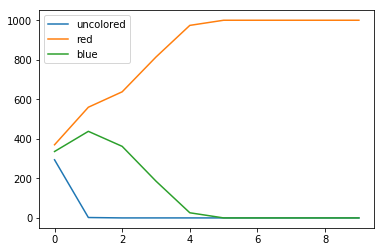

In [61]:
model = SlushModel(num_nodes, 50, 20)
for i in range(num_rounds):
    model.step()
counts = model.datacollector.get_model_vars_dataframe()
counts.plot()